In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import re

from feature_engine.transformation import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree, export_text

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [3]:
dataset = pd.read_csv('train.csv')
print(dataset.shape)

dataset.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Variable Types

In [5]:
dataset['Survived'] = dataset['Survived'].astype('object')
dataset['Pclass'] = dataset['Pclass'].astype('object')

In [6]:
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtype == 'O' and feature != 'Survived']
print('Total number of Categorical Numbers: ', len(categorical_features))

categorical_features

Total number of Categorical Numbers:  6


['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [7]:
numerical_features = [feature for feature in dataset.columns if feature not in categorical_features and feature != 'Survived']
print('Total number of Numerical Features: ', len(numerical_features))

numerical_features

Total number of Numerical Features:  5


['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']

# Splitting the dataset into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(['Survived'], axis=1),
    dataset['Survived'],
    test_size=0.3,
    random_state=0
)

# Missing Data


## Numerical Features

### Age

In [9]:
from feature_engine.imputation import RandomSampleImputer

age_imputer = RandomSampleImputer(variables = ['Age'], random_state = 1111)
age_imputer.fit(X_train, y_train)

X_train = age_imputer.transform(X_train)
X_test = age_imputer.transform(X_test)

In [10]:
print(X_train['Age'].isnull().sum(), X_test['Age'].isnull().sum())

0 0


In [11]:
# age_transform = PowerTransformer(variables = ['Age'], exp = 0.65)
# age_transform.fit(X_train, y_train)

# X_train = age_transform.transform(X_train)
# X_test = age_transform.transform(X_test)

In [12]:
print(X_train['Age'].isnull().sum(), X_test['Age'].isnull().sum())

0 0


### Fare

In [13]:
fare_mean = X_train['Fare'].mean()

In [14]:
from feature_engine.transformation import YeoJohnsonTransformer

fare_yeojohnson = YeoJohnsonTransformer()
fare_yeojohnson.fit(X_train, y_train)

X_train = fare_yeojohnson.transform(X_train)
X_test = fare_yeojohnson.transform(X_test)

In [15]:
print(X_train['Fare'].isnull().sum(), X_test['Fare'].isnull().sum())

0 0


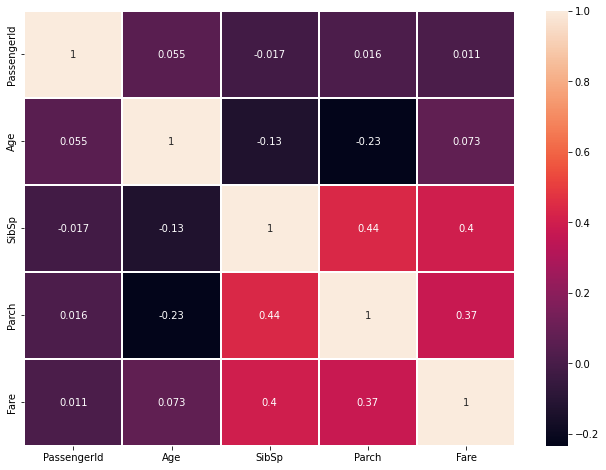

In [16]:
fig = plt.figure(figsize=(11, 8))
sns.heatmap(X_train.corr(), annot = True, linewidths=0.3)

plt.show()

## Categorical Features

### Ticket

In [17]:
def ticket_transform(transform_dataset):
    
    dataset = transform_dataset.copy()
    
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'alpha_numeric_ticket' if re.search('[a-zA-Z]', str(x)) else x)

    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'three_digit_ticket' if len(str(x)) == 3 else x)
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'four_digit_ticket' if len(str(x)) == 4 else x)
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'five_digit_ticket' if len(str(x)) == 5 else x)
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'six_digit_ticket' if len(str(x)) == 6 else x)
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x: 'seven_digit_ticket' if len(str(x)) == 7 else x)
    
    return dataset

In [18]:
X_train = ticket_transform(X_train)
X_test = ticket_transform(X_test)

### Name

In [19]:
def name_transform(transform_dataset):
    
    dataset = transform_dataset.copy()
    
    dataset['Name'] = dataset['Name'].apply(lambda x: 'Mr' if 'Mr.' in x else x)
    dataset['Name'] = dataset['Name'].apply(lambda x: 'Mrs' if 'Mrs.' in x else x)
    dataset['Name'] = dataset['Name'].apply(lambda x: 'Miss' if 'Miss' in x else x)
    dataset['Name'] = dataset['Name'].apply(lambda x: 'Master' if 'Master' in x else x)
    dataset['Name'] = dataset['Name'].apply(lambda x: 'Other' if len(str(x)) > 6 else x)
    
    return dataset

In [20]:
X_train = name_transform(X_train)
X_test = name_transform(X_test)

### Cabin

In [21]:
dataset['Cabin'].isna().sum() / len(dataset['Cabin'])

0.7710437710437711

**Cabin consists of 77% of missing values, So we drop it.**

### Embarked

In [22]:
X_train['Embarked'] = X_train['Embarked'].fillna(statistics.mode(X_train['Embarked']))
X_test['Embarked'] = X_test['Embarked'].fillna(statistics.mode(X_train['Embarked']))

# Feature Mappings

In [23]:
pClass_mappings = {1: 'Upper', 2: 'Middle', 3: 'Lower'}
embarked_mappings = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}

In [24]:
X_train['Pclass'] = X_train['Pclass'].map(pClass_mappings)
X_test['Pclass'] = X_test['Pclass'].map(pClass_mappings)

X_train['Embarked'] = X_train['Embarked'].map(embarked_mappings)
X_test['Embarked'] = X_test['Embarked'].map(embarked_mappings)

# Dropping Features

In [25]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
857,166.440571,Upper,Mr,male,28.097901,-0.000000,-0.000000,six_digit_ticket,2.683549,E17,Southampton
52,22.320788,Upper,Mrs,female,27.193267,0.322062,-0.000000,alpha_numeric_ticket,3.308138,D33,Cherbourg
386,94.283411,Lower,Master,male,0.925751,0.382529,0.247722,alpha_numeric_ticket,3.027278,NaN,Southampton
124,41.792747,Upper,Mr,male,29.441833,-0.000000,0.235036,five_digit_ticket,3.312157,D26,Southampton
578,125.743433,Lower,Mrs,female,22.552153,0.322062,-0.000000,four_digit_ticket,2.296500,NaN,Cherbourg


In [26]:
X_train = X_train.drop(['PassengerId', 'Cabin'], axis = 1)
X_test = X_test.drop(['PassengerId', 'Cabin'], axis = 1)

# One Hot Encoding

In [27]:
X_train['Name'].value_counts()

Mr        367
Miss      121
Mrs        88
Master     31
Other      16
Name: Name, dtype: int64

In [28]:
X_train['Ticket'].value_counts()

six_digit_ticket        300
alpha_numeric_ticket    166
five_digit_ticket        89
four_digit_ticket        59
seven_digit_ticket        8
three_digit_ticket        1
Name: Ticket, dtype: int64

In [29]:
top_three_categories = ['Name', 'Ticket']
ohe = ['Pclass', 'Sex', 'Embarked']

In [30]:
from feature_engine.encoding import OneHotEncoder

ohc_ticket = OneHotEncoder(top_categories = 3, variables = top_three_categories)
ohc_ticket.fit(X_train, y_train)

X_train = ohc_ticket.transform(X_train)
X_test = ohc_ticket.transform(X_test)

In [31]:
ohe = OneHotEncoder(variables = ohe)
ohe.fit(X_train, y_train)

X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

# Scale the Variables

In [32]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(X_train) 

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [33]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# Encoding and Ecoding Fns for target feature

In [34]:
def target_encode(value):
    target_dict = {0: 'Not_Survived', 1: 'Survived'}
    
    return target_dict[value]

def target_decode(value):
    target_dict = {'Not_Survived': 0, 'Survived': 1}
    
    return target_dict[value]

In [35]:
y_train = y_train.apply(target_encode)
y_test = y_test.apply(target_encode)

# Feature Selection

In [36]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=10,
)

rfa = RecursiveFeatureAddition(
    variables=None,  
    estimator=model,  
    scoring='roc_auc',  
    threshold=0.0001,  
    cv=2,
)

rfa.fit(X_train,y_train)

X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

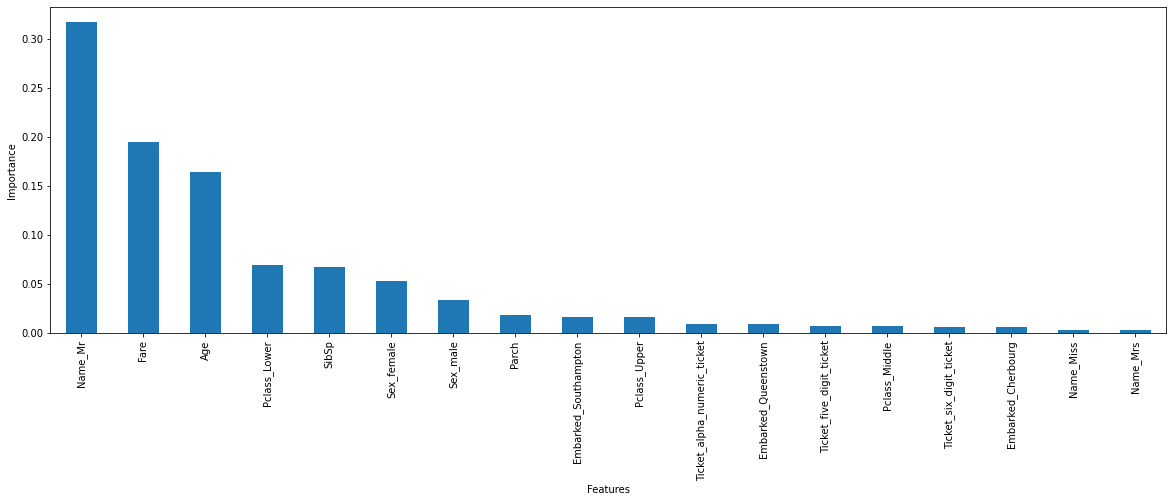

In [37]:
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Over Sampling

In [38]:
X_train.head()

,Fare,Name_Mr,Pclass_Lower
0,0.631967,1.0,0.0
1,0.779056,0.0,0.0
2,0.712914,0.0,1.0
3,0.780002,1.0,0.0
4,0.540818,0.0,1.0


In [39]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

sm = SMOTE(
    sampling_strategy=0.8,  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=4,
    n_jobs=4
)

In [40]:

tl = TomekLinks(
    sampling_strategy='majority',
    n_jobs=4)

smtomek = SMOTETomek(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    smote=sm,
    tomek=tl,
    n_jobs=4
)

X_train, y_train = smtomek.fit_resample(X_train, y_train)

In [41]:
y_train = y_train.apply(target_decode)
y_test = y_test.apply(target_decode)

# Models

In [42]:
def print_metrics(y_train_pred, y_test_pred):
    
#     y_train_pred = pd.Series(y_train_pred).apply(target_decode)
#     y_test_pred = pd.Series(y_test_pred).apply(target_decode)
    
    print()
    
    print("Train set accuracy_score: ", accuracy_score(y_train, y_train_pred))
    print("Test set accuracy_score: ", accuracy_score(y_test, y_test_pred))
    
    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set classification_report: \n\n", classification_report(y_train, y_train_pred))
    print()
    print("Test set classification_report: \n\n", classification_report(y_test, y_test_pred))

    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set roc_auc_score: ", roc_auc_score(y_train, y_train_pred))
    print("Test set roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
    
    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set confusion_matrix: \n\n", confusion_matrix(y_train, y_train_pred))
    print()
    print("Test set confusion_matrix: \n\n", confusion_matrix(y_test, y_test_pred))

In [43]:
def get_model_score(classifier, train, test):
    
    return round(classifier.score(train, test) * 100, 2)

In [44]:
def get_precision_recall(y_train, y_train_pred, y_test, y_test_pred):
    
    train_precision = round(precision_score(y_train, y_train_pred), 2)
    train_recall = round(recall_score(y_train, y_train_pred), 2)

    test_precision = round(precision_score(y_test, y_test_pred), 2)
    test_recall = round(recall_score(y_test, y_test_pred), 2)
    
    return train_precision, train_recall, test_precision, test_recall

## GradientBoostingClassifier

In [45]:
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=10)

gradient_boosting_classifier.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=10)

In [46]:
y_train_pred = gradient_boosting_classifier.predict(X_train)
y_test_pred = gradient_boosting_classifier.predict(X_test)

In [47]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.8967551622418879
Test set accuracy_score:  0.8134328358208955
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.92      0.91       374
           1       0.90      0.87      0.88       304

    accuracy                           0.90       678
   macro avg       0.90      0.89      0.90       678
weighted avg       0.90      0.90      0.90       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.80      0.84       168
           1       0.72      0.83      0.77       100

    accuracy                           0.81       268
   macro avg       0.80      0.82      0.81       268
weighted avg       0.82      0.81      0.82       268

--------------------------------------------------------------

In [48]:
gradient_boosting_train_score = get_model_score(gradient_boosting_classifier, X_train, y_train)
gradient_boosting_test_score = get_model_score(gradient_boosting_classifier, X_test, y_test)

gradient_boosting_train_precision, gradient_boosting_train_recall, gradient_boosting_test_precision, gradient_boosting_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

### GP Minimize

In [49]:
gradient_boosting_GB_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=10, verbose=True)

In [50]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score


param_grid = [
    Integer(200, 2500, name = 'n_estimators'),
    Integer(1, 10, name = 'max_depth'),
    Real(0.01, 0.99, name = 'learning_rate'),
    Integer(2, 20, name = 'min_samples_split'),
    Integer(1, 30, name = 'min_samples_leaf'),
    Categorical(['log_loss', 'deviance', 'exponential'], name = 'loss')    
]

In [51]:
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gradient_boosting_GB_classifier.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gradient_boosting_GB_classifier, 
            X_train,
            y_train,
            cv=5,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

In [52]:

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='gp_hedge', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

C:\Users\neere\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [53]:
"Best score=%.4f" % gp_.fun

'Best score=-0.8540'

In [54]:
print(gp_.x)

[1057, 5, 0.01, 20, 28, 'log_loss']


In [55]:
# # 84.76 -> [1720, 8, 0.013932961970339811, 2, 6, 'deviance']
# # 85.21 -> [200, 6, 0.05189672758953824, 20, 1, 'deviance']
# # 84.93 -> [2202, 6, 0.01, 18, 8, 'deviance']

In [56]:
# plot_convergence(gp_)

In [57]:
gradient_boosting_GB_classifier = GradientBoostingClassifier(n_estimators=1914, max_depth=5, learning_rate = 0.01, min_samples_split = 3, min_samples_leaf = 1, loss = 'log_loss')
gradient_boosting_GB_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_split=3,
                           n_estimators=1914)

In [58]:
y_train_pred = gradient_boosting_GB_classifier.predict(X_train)
y_test_ored = gradient_boosting_GB_classifier.predict(X_test)

In [59]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.9056047197640118
Test set accuracy_score:  0.8134328358208955
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.90      0.93      0.92       374
           1       0.91      0.88      0.89       304

    accuracy                           0.91       678
   macro avg       0.91      0.90      0.90       678
weighted avg       0.91      0.91      0.91       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.80      0.84       168
           1       0.72      0.83      0.77       100

    accuracy                           0.81       268
   macro avg       0.80      0.82      0.81       268
weighted avg       0.82      0.81      0.82       268

--------------------------------------------------------------

In [60]:
gradient_boosting_GB_train_score = get_model_score(gradient_boosting_GB_classifier, X_train, y_train)
gradient_boosting_GB_test_score = get_model_score(gradient_boosting_GB_classifier, X_test, y_test)

gradient_boosting_GB_train_precision, gradient_boosting_GB_train_recall, gradient_boosting_GB_test_precision, gradient_boosting_GB_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

### Hyperparameter Tuning

In [61]:
# gbc = GradientBoostingClassifier()

# parameters = {
#     "n_estimators":range(60, 300, 10),
#     "max_depth":range(2, 10),
#     "learning_rate":[0.01,0.1,1,10,100]
# }

# from sklearn.model_selection import GridSearchCV
# cv = GridSearchCV(gbc,parameters,cv=5)

# cv.fit(X_train, y_train)

In [62]:
# def display(results):
#     print(f'Best parameters are: {results.best_params_}')
#     print("\n")
#     mean_score = results.cv_results_['mean_test_score']
#     std_score = results.cv_results_['std_test_score']
#     params = results.cv_results_['params']
#     for mean,std,params in zip(mean_score,std_score,params):
#         print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [63]:
# cv.best_estimator_ # GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=80)

In [64]:
# gradient_boosting_grid_classifier = cv.best_estimator_
# gradient_boosting_grid_classifier.fit(X_train, y_train)

In [65]:
# y_train_pred = gradient_boosting_grid_classifier.predict(X_train)
# y_test_pred = gradient_boosting_grid_classifier.predict(X_test)

In [66]:
# print_metrics(y_train_pred, y_test_pred)

## AdaBoost Classifier

In [67]:
classifier_adaboost = AdaBoostClassifier()
classifier_adaboost.fit(X_train, y_train)

AdaBoostClassifier()

In [68]:
y_train_pred = classifier_adaboost.predict(X_train)
y_test_pred = classifier_adaboost.predict(X_test)

In [69]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.827433628318584
Test set accuracy_score:  0.7985074626865671
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.82      0.89      0.85       374
           1       0.84      0.76      0.80       304

    accuracy                           0.83       678
   macro avg       0.83      0.82      0.82       678
weighted avg       0.83      0.83      0.83       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.85      0.83      0.84       168
           1       0.72      0.75      0.74       100

    accuracy                           0.80       268
   macro avg       0.78      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

---------------------------------------------------------------

In [70]:
adabost_train_score = get_model_score(classifier_adaboost, X_train, y_train)
adabost_test_score = get_model_score(classifier_adaboost, X_test, y_test)

adaboost_train_precision, adaboost_train_recall, adaboost_test_precision, adaboost_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## Logistic Regression

In [71]:
classifier = LogisticRegression(C = 1/0.001, max_iter=4000)
classifier.fit(X_train, y_train)

LogisticRegression(C=1000.0, max_iter=4000)

In [72]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

In [73]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.7905604719764012
Test set accuracy_score:  0.7761194029850746
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.81      0.81      0.81       374
           1       0.77      0.76      0.77       304

    accuracy                           0.79       678
   macro avg       0.79      0.79      0.79       678
weighted avg       0.79      0.79      0.79       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.86      0.77      0.81       168
           1       0.67      0.79      0.72       100

    accuracy                           0.78       268
   macro avg       0.76      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268

--------------------------------------------------------------

In [74]:
logit_train_score = get_model_score(classifier, X_train, y_train)
logit_test_score = get_model_score(classifier, X_test, y_test)

logit_train_precision, logit_train_recall, logit_test_precision, logit_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## XG Boost

In [75]:
xgboost_classifier = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')
xgboost_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [76]:
y_train_pred = xgboost_classifier.predict(X_train)
y_test_pred = xgboost_classifier.predict(X_test)

In [77]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.8908554572271387
Test set accuracy_score:  0.8171641791044776
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.91      0.90       374
           1       0.89      0.86      0.88       304

    accuracy                           0.89       678
   macro avg       0.89      0.89      0.89       678
weighted avg       0.89      0.89      0.89       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.81      0.85       168
           1       0.72      0.83      0.77       100

    accuracy                           0.82       268
   macro avg       0.81      0.82      0.81       268
weighted avg       0.83      0.82      0.82       268

--------------------------------------------------------------

In [78]:
xgboost_train_score = get_model_score(xgboost_classifier, X_train, y_train)
xgboost_test_score = get_model_score(xgboost_classifier, X_test, y_test)

xgboost_train_precision, xgboost_train_recall, xgboost_test_precision, xgboost_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

### Grid Search

In [79]:
# estimator = xgboost.XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=909
# )

# parameters = {
#     'max_depth': range (2, 20, 1),
#     'n_estimators': range(60, 400, 10),
#     'learning_rate': [0.1, 0.01, 0.01, 0.2, 0.02, 0.002, 0.3, 0.03, 0.003]
# }

# xgboost_grid_search = GridSearchCV(
#     estimator = estimator,
#     param_grid = parameters,
#     scoring = 'accuracy',
#     n_jobs = 10,
#     cv = 5,
#     verbose=True
# )

# xgboost_grid_search.fit(X_train, y_train)

In [80]:
# xgboost_grid_search.best_params_ # {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 140}

In [81]:
# xgboost.XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 280)

xgboost_grid_search = xgboost.XGBClassifier(learning_rate = 0.01, max_depth = 5, n_estimators = 140)
xgboost_grid_search.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [82]:
y_train_pred = xgboost_grid_search.predict(X_train)
y_test_pred = xgboost_grid_search.predict(X_test)

In [83]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.8628318584070797
Test set accuracy_score:  0.8171641791044776
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.86      0.89      0.88       374
           1       0.86      0.83      0.84       304

    accuracy                           0.86       678
   macro avg       0.86      0.86      0.86       678
weighted avg       0.86      0.86      0.86       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.88      0.82      0.85       168
           1       0.73      0.81      0.77       100

    accuracy                           0.82       268
   macro avg       0.80      0.82      0.81       268
weighted avg       0.82      0.82      0.82       268

--------------------------------------------------------------

In [84]:
xgboost_grid_train_score = get_model_score(xgboost_grid_search, X_train, y_train)
xgboost_grid_test_score = get_model_score(xgboost_grid_search, X_test, y_test)

xgboost_grid_train_precision, xgboost_grid_train_recall, xgboost_grid_test_precision, xgboost_grid_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## KNN

In [85]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', metric = 'minkowski', p = 1)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [86]:
y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)

print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.9056047197640118
Test set accuracy_score:  0.8022388059701493
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.94      0.92       374
           1       0.93      0.86      0.89       304

    accuracy                           0.91       678
   macro avg       0.91      0.90      0.90       678
weighted avg       0.91      0.91      0.91       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.87      0.81      0.84       168
           1       0.71      0.79      0.75       100

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268

--------------------------------------------------------------

In [87]:
knn_train_score = get_model_score(knn_classifier, X_train, y_train)
knn_test_score = get_model_score(knn_classifier, X_test, y_test)

knn_train_precision, knn_train_recall, knn_test_precision, knn_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## Navie Bayes

In [88]:
from sklearn.naive_bayes import GaussianNB
navie_bayes_classifier = GaussianNB()
navie_bayes_classifier.fit(X_train, y_train)

GaussianNB()

In [89]:
y_train_pred = navie_bayes_classifier.predict(X_train)
y_test_pred = navie_bayes_classifier.predict(X_test)

print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.7831858407079646
Test set accuracy_score:  0.7723880597014925
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.81      0.79      0.80       374
           1       0.75      0.77      0.76       304

    accuracy                           0.78       678
   macro avg       0.78      0.78      0.78       678
weighted avg       0.78      0.78      0.78       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.86      0.76      0.81       168
           1       0.66      0.80      0.72       100

    accuracy                           0.77       268
   macro avg       0.76      0.78      0.77       268
weighted avg       0.79      0.77      0.78       268

--------------------------------------------------------------

In [90]:
navie_bayes_train_score = get_model_score(navie_bayes_classifier, X_train, y_train)
navie_bayes_test_score = get_model_score(navie_bayes_classifier, X_test, y_test)

navie_bayes_train_precision, navie_bayes_train_recall, navie_bayes_test_precision, navie_bayes_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## SVC

In [91]:
svc_classifier = SVC(kernel = 'poly', random_state = 0, C = 10)
svc_classifier.fit(X_train, y_train)

SVC(C=10, kernel='poly', random_state=0)

In [92]:
y_train_pred = svc_classifier.predict(X_train)
y_test_pred = svc_classifier.predict(X_test)

print_metrics(pd.Series(y_train_pred), pd.Series(y_test_pred))


Train set accuracy_score:  0.8097345132743363
Test set accuracy_score:  0.7910447761194029
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.78      0.91      0.84       374
           1       0.86      0.69      0.77       304

    accuracy                           0.81       678
   macro avg       0.82      0.80      0.80       678
weighted avg       0.82      0.81      0.81       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.83      0.84      0.83       168
           1       0.72      0.71      0.72       100

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268

--------------------------------------------------------------

In [93]:
svc_train_score = round(svc_classifier.score(X_train, y_train) * 100, 2)
svc_test_score = round(svc_classifier.score(X_test, y_test) * 100, 2)

In [94]:
svc_train_score = get_model_score(svc_classifier, X_train, y_train)
svc_test_score = get_model_score(svc_classifier, X_test, y_test)

svc_train_precision, svc_train_recall, svc_test_precision, svc_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

## Decision Tree

In [95]:
decision_tree_classifier = DecisionTreeClassifier(random_state=192)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=192)

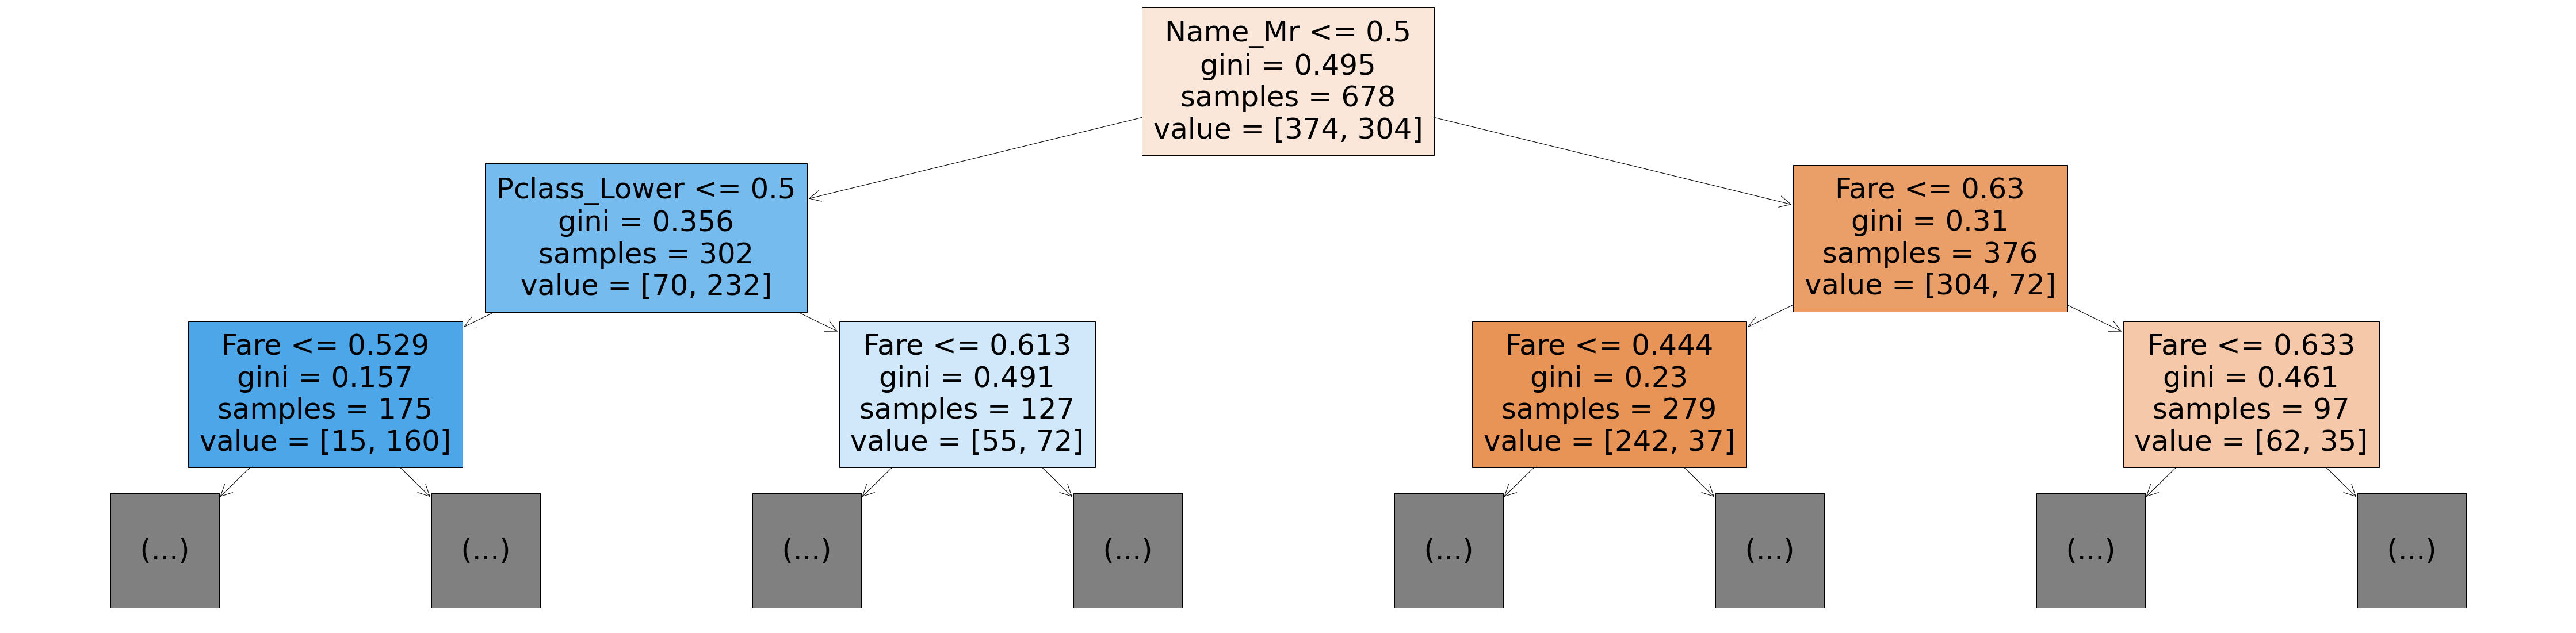

In [96]:
plt.figure(figsize =(80,20))

plot_tree(decision_tree_classifier, feature_names=X_train.columns, max_depth=2, filled=True)

plt.show()

In [97]:
y_train_pred = decision_tree_classifier.predict(X_train)
y_test_pred = decision_tree_classifier.predict(X_test)

In [98]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.9056047197640118
Test set accuracy_score:  0.8022388059701493
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.89      0.94      0.92       374
           1       0.93      0.86      0.89       304

    accuracy                           0.91       678
   macro avg       0.91      0.90      0.90       678
weighted avg       0.91      0.91      0.91       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.87      0.81      0.84       168
           1       0.71      0.79      0.75       100

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268

--------------------------------------------------------------

In [99]:
decision_tree_train_score = get_model_score(decision_tree_classifier, X_train, y_train)
decision_tree_test_score = get_model_score(decision_tree_classifier, X_test, y_test)

decision_tree_train_precision, decision_tree_train_recall, decision_tree_test_precision, decision_tree_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

### Grid Search

In [100]:
decision_tree_classifier = DecisionTreeClassifier(random_state=192)

parameters = {
    'max_depth': range (2, 20, 1),
    'min_samples_split': [2, 3, 4, 6, 7, 8],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

decision_tree_grid_search = GridSearchCV(
    estimator = decision_tree_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

decision_tree_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=192),
             n_jobs=10,
             param_grid={'max_depth': range(2, 20),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4, 6, 7, 8]},
             scoring='accuracy', verbose=True)

In [101]:
print(decision_tree_grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=6, max_features='sqrt', random_state=192)


In [102]:
decision_tree_grid_search = decision_tree_grid_search.best_estimator_
decision_tree_grid_search.fit(X_train, y_train)

y_train_pred = decision_tree_grid_search.predict(X_train)
y_test_pred = decision_tree_grid_search.predict(X_test)

In [103]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.8628318584070797
Test set accuracy_score:  0.8097014925373134
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

               precision    recall  f1-score   support

           0       0.86      0.90      0.88       374
           1       0.87      0.82      0.84       304

    accuracy                           0.86       678
   macro avg       0.86      0.86      0.86       678
weighted avg       0.86      0.86      0.86       678


Test set classification_report: 

               precision    recall  f1-score   support

           0       0.88      0.81      0.84       168
           1       0.72      0.81      0.76       100

    accuracy                           0.81       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.81      0.81       268

--------------------------------------------------------------

In [104]:
decision_tree_grid_search_train_score = get_model_score(decision_tree_grid_search, X_train, y_train)
decision_tree_grid_search_test_score = get_model_score(decision_tree_grid_search, X_test, y_test)

decision_tree_grid_search_train_precision, decision_tree_grid_search_train_recall, decision_tree_grid_search_test_precision, decision_tree_grid_search_test_recall = get_precision_recall(y_train, y_train_pred, y_test, y_test_pred)

# Summary Metrics

In [105]:
models = pd.DataFrame({
    
    'Model': ['GradientBoosting_GP_Classifier', 'GradientBoosting_Classifier', 'AdaBoost_Classifier', 'Logistic_Regression', 'XGBoost', 'XGBoost_GridSearch', 
              'KNN', 'Navie_Bayes', 'SVC', 'Decision_Tree_Classifier', 'Decision_Tree_Classifier_GridSearch'],
    
    'Train_set_accuracy': [gradient_boosting_GB_train_score, gradient_boosting_train_score, adabost_train_score, logit_train_score, xgboost_train_score, xgboost_grid_train_score, 
                           knn_train_score, navie_bayes_train_score, svc_train_score, decision_tree_train_score, decision_tree_grid_search_train_score],
    
    'Test_set_accuracy': [gradient_boosting_test_score, gradient_boosting_test_score, adabost_test_score, logit_test_score, xgboost_test_score, xgboost_grid_test_score, 
                          knn_test_score, navie_bayes_test_score, svc_test_score, decision_tree_test_score, decision_tree_grid_search_test_score],
    
    'Train_precision': [gradient_boosting_GB_train_precision, gradient_boosting_train_precision, adaboost_train_precision, logit_train_precision, xgboost_train_precision, xgboost_grid_train_precision, knn_train_precision, 
                        navie_bayes_train_precision, svc_train_precision, decision_tree_train_precision, decision_tree_grid_search_train_precision],
    
    'Test_precision': [gradient_boosting_test_precision, gradient_boosting_test_precision, adaboost_test_precision, logit_test_precision, xgboost_test_precision, xgboost_grid_test_precision, knn_test_precision, 
                       navie_bayes_test_precision, svc_test_precision, decision_tree_test_precision, decision_tree_grid_search_test_precision],
    
    'Train_recall': [gradient_boosting_GB_train_recall, gradient_boosting_train_recall, adaboost_train_recall, logit_train_recall, xgboost_train_recall, xgboost_grid_train_recall, knn_train_recall,
                     navie_bayes_train_recall, svc_train_recall, decision_tree_train_recall, decision_tree_grid_search_train_recall],
    
    'Test_recall': [gradient_boosting_GB_test_recall, gradient_boosting_test_recall, adaboost_test_recall, logit_test_recall, xgboost_test_recall, xgboost_grid_test_recall, knn_test_recall,
                    navie_bayes_test_recall, svc_test_recall, decision_tree_test_recall, decision_tree_grid_search_test_recall]
})

In [106]:
models.sort_values(by = 'Train_set_accuracy', ascending = True).sort_values(by = 'Test_set_accuracy', ascending = False).reset_index(False)

,index,Model,Train_set_accuracy,Test_set_accuracy,Train_precision,Test_precision,Train_recall,Test_recall
0,5,XGBoost_GridSearch,86.28,81.72,0.86,0.73,0.83,0.81
1,4,XGBoost,89.09,81.72,0.89,0.72,0.86,0.83
2,1,GradientBoosting_Classifier,89.68,81.34,0.90,0.72,0.87,0.83
3,0,GradientBoosting_GP_Classifier,90.56,81.34,0.91,0.72,0.88,0.83
4,10,Decision_Tree_Classifier_GridSearch,86.28,80.97,0.87,0.72,0.82,0.81
5,6,KNN,90.56,80.22,0.93,0.71,0.86,0.79
6,9,Decision_Tree_Classifier,90.56,80.22,0.93,0.71,0.86,0.79
7,2,AdaBoost_Classifier,82.74,79.85,0.84,0.72,0.76,0.75
8,8,SVC,80.97,79.10,0.86,0.72,0.69,0.71
9,3,Logistic_Regression,79.06,77.61,0.77,0.67,0.76,0.79


# Scoring New Data

In [107]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)

test_data.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [108]:
# test_data = test_data.drop(['PassengerId', 'Cabin'], axis = 1)
# test_data.head()

## Missing Data

In [109]:
test_data.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

### Numerical Features

#### Age

In [110]:
test_data = age_imputer.transform(test_data)

In [111]:
# test_data = age_transform.transform(test_data)

#### Fare

In [112]:
test_data['Fare'] = test_data['Fare'].fillna(fare_mean)

In [113]:
test_data = fare_yeojohnson.transform(test_data)

### Categorical Features

#### Ticket

In [114]:
test_data = ticket_transform(test_data)

#### Name

In [115]:
test_data = name_transform(test_data)

### Feature Mapping

In [116]:
test_data['Pclass'] = test_data['Pclass'].map(pClass_mappings)
test_data['Embarked'] = test_data['Embarked'].map(embarked_mappings)

### Dropping Features

In [117]:
test_data = test_data.drop(['PassengerId', 'Cabin'], axis = 1)

### One Hot Encoding

In [118]:
test_data = ohc_ticket.transform(test_data)

In [119]:
test_data = ohe.transform(test_data)

### Scale the test data

In [120]:
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [121]:
test_data.head()

,Age,SibSp,Parch,Fare,Name_Mr,Name_Miss,Name_Mrs,Ticket_six_digit_ticket,Ticket_alpha_numeric_ticket,Ticket_five_digit_ticket,Pclass_Upper,Pclass_Lower,Pclass_Middle,Sex_male,Sex_female,Embarked_Southampton,Embarked_Cherbourg,Embarked_Queenstown
0,0.494854,0.00000,0.0000,0.445558,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.642450,0.83662,0.0000,0.428040,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.809648,0.00000,0.0000,0.478843,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.401299,0.00000,0.0000,0.461379,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.336119,0.83662,0.9373,0.515774,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


### Feature Selection

In [122]:
test_data = pipe.transform(test_data)
test_data = rfa.transform(test_data)

### Predicting

In [123]:
predictions = gradient_boosting_GB_classifier.predict(test_data)

### Submitting to Kaggle

In [124]:
submit_predictions = pd.read_csv('gender_submission.csv')
submit_predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [125]:
submit_predictions['Survived'] = predictions
submit_predictions['Survived'].head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [126]:
submit_predictions[['PassengerId', 'Survived']].to_csv('gender_submission.csv', index = False)